In [1]:
%load_ext watermark

import dask.array 
import flox
import numpy as np
import pandas as pd
import xarray as xr

%watermark -iv

flox  : 0.6.2.dev6+gc370b5d
xarray: 2022.9.0
sys   : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]
dask  : 2022.9.2
pandas: 1.5.0
json  : 2.0.9
numpy : 1.23.3



## Groupby: smaller

The original problem is 3D : `time, lat, lon`. I've made it 4d so it's easy to scale up: just increase `NZ` and adjust chunk size `ZCHUNKS`

In [2]:
NZ = 1
ZCHUNKS= -1

oisst = xr.DataArray(
    dask.array.random.random((14532, NZ, 720, 1440), chunks=(20, ZCHUNKS, -1, -1)),
    dims=("time", "z", "lat", "lon"),
    coords={"time": pd.date_range("1981-09-01 12:00", "2021-06-14 12:00", freq="D")},
    name="sst",
)
oisst

,Array,Chunk
Bytes,112.26 GiB,158.20 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,1 Graph Layer,727 Chunks
Type,float64,numpy.ndarray


## apply / reduce

`reduce` is like `apply` but the user function receives the underlying array (e.g. `dask.array`) time, not an Xarray object.

`apply` is the more common use-case but `reduce` lowers it down to a array problem and remove some of the xarray pieces.

In [3]:
oisst.groupby("time.dayofyear").reduce(np.mean)

,Array,Chunk
Bytes,2.83 GiB,7.91 MiB
Shape,"(366, 1, 720, 1440)","(1, 1, 720, 1440)"
Count,1831 Graph Layers,366 Chunks
Type,float64,numpy.ndarray


meidan is epic; `dask.array.median` is rechunking to one chunk along `time`

In [4]:
oisst.groupby("time.dayofyear").reduce(np.median)

,Array,Chunk
Bytes,2.83 GiB,3.19 MiB
Shape,"(366, 1, 720, 1440)","(1, 1, 457, 916)"
Count,1466 Graph Layers,3294 Chunks
Type,float64,numpy.ndarray


similar but less crazy

In [5]:
oisst.groupby("time.month").reduce(np.median)

/glade/u/home/dcherian/miniconda3/envs/ncar-challenge/lib/python3.10/site-packages/dask/array/core.py:1761: PerformanceWarning: Increasing number of chunks by factor of 13
  return da_func(*args, **kwargs)


,Array,Chunk
Bytes,94.92 MiB,105.05 kiB
Shape,"(12, 1, 720, 1440)","(1, 1, 81, 166)"
Count,74 Graph Layers,13068 Chunks
Type,float64,numpy.ndarray


### What's happening?

We index the underlying dask array `num_groups` times with different indexers : `np.array[ndim=1, int]`

In [6]:
gb = oisst.groupby("time.month")
for month, idxr in zip(gb._unique_coord.data, gb._group_indices):
    print(f"{month}: {len(idxr)} indices")

1: 1240 indices
2: 1130 indices
3: 1240 indices
4: 1200 indices
5: 1240 indices
6: 1184 indices
7: 1209 indices
8: 1209 indices
9: 1200 indices
10: 1240 indices
11: 1200 indices
12: 1240 indices


So something like

In [7]:
np.take(oisst.data, indices=idxr, axis=oisst.get_axis_num("time"))

,Array,Chunk
Bytes,9.58 GiB,158.20 MiB
Shape,"(1240, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,2 Graph Layers,101 Chunks
Type,float64,numpy.ndarray


for each group, apply the operation, then concatenate to form the final result

For `"time.dayofyear"` we do this 366 times.

## Groupby: bigger

To scale this just change the start date. The actual dataset begins in 1979

In [8]:
# actually 30 years 1979 - 2020
time = pd.date_range("2020-01-01", "2020-12-31 23:59", freq="3H")
nwm = xr.DataArray(
    dims=("time", "y", "x"), 
    data=dask.array.random.random(
        (len(time), 15360, 18432), chunks=(224, 350, 350)
    ),
    coords={"time": time}
)
nwm

,Array,Chunk
Bytes,6.03 TiB,209.35 MiB
Shape,"(2928, 15360, 18432)","(224, 350, 350)"
Count,1 Graph Layer,32648 Chunks
Type,float64,numpy.ndarray


In [9]:
# default xarray approach - "shuffle"
nwm.groupby("time.dayofyear").reduce(np.mean)

,Array,Chunk
Bytes,772.03 GiB,0.93 MiB
Shape,"(366, 15360, 18432)","(1, 350, 350)"
Count,1100 Graph Layers,853512 Chunks
Type,float64,numpy.ndarray


###  Solution?

We can make this a single indexing problem

In [10]:
gb = oisst.groupby("time.month")
all_indexes = np.concatenate(gb._group_indices)

The simplest way to shuffle

In [11]:
shuffled = oisst.data[all_indexes, ...]
shuffled

,Array,Chunk
Bytes,112.26 GiB,158.20 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,2 Graph Layers,1181 Chunks
Type,float64,numpy.ndarray


Ooh we can make use of https://github.com/dask/dask/pull/3901

In [12]:
from dask.array.slicing import shuffle_slice

shuffled = shuffle_slice(oisst.data, all_indexes)
shuffled

,Array,Chunk
Bytes,112.26 GiB,158.20 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,4 Graph Layers,727 Chunks
Type,float64,numpy.ndarray


Since all elements in a group are sequential in `shuffled` we can just slice them out

In [65]:
group_len = [len(idxr) for idxr in gb._group_indices]
edges = np.cumsum([0, *group_len])

results = []
for left, right in zip(edges[:-1], edges[1:]):
    group = shuffled[slice(left, right), ...]
    results.append(group.mean(axis=0))

In [64]:
dask.array.concatenate(results, axis=0)

dask.array<concatenate, shape=(12, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>

compare to

## (incomplete) NWM 2D groupby

mimics county aggregation

In [35]:
nwm

,Array,Chunk
Bytes,6.03 TiB,209.35 MiB
Shape,"(2928, 15360, 18432)","(224, 350, 350)"
Count,1 Graph Layer,32648 Chunks
Type,float64,numpy.ndarray


In [45]:
32*32

1024

In [48]:
x = np.repeat(np.arange(64), nwm.sizes["x"]//64)
y = np.repeat(np.arange(64), nwm.sizes["y"]//64)

In [57]:
county = xr.DataArray(x[np.newaxis, :] * y[:, np.newaxis], dims=("y", "x"))

In [58]:
county

<xarray.DataArray (y: 15360, x: 18432)>
array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 3969, 3969, 3969],
       [   0,    0,    0, ..., 3969, 3969, 3969],
       [   0,    0,    0, ..., 3969, 3969, 3969]])
Dimensions without coordinates: y, x

In [ ]:
nwm.groupby(county)


KeyboardInterrupt



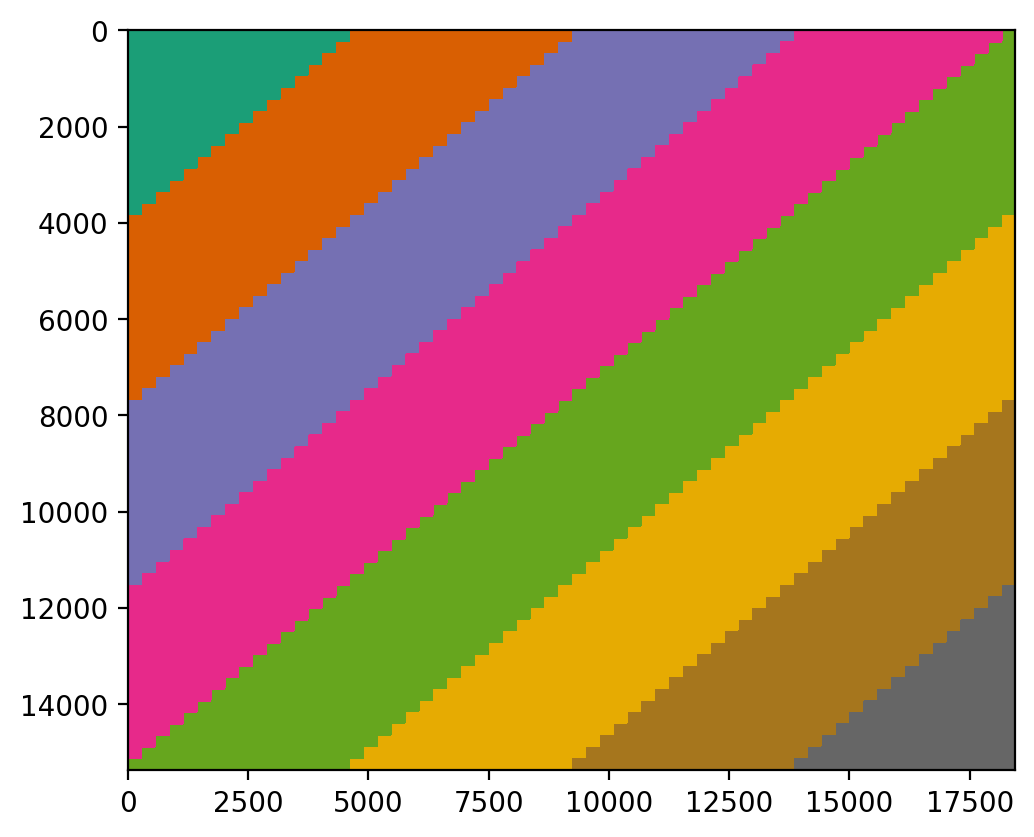

In [54]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.imshow(county, cmap=mpl.cm.Dark2)